# [Going Deeper(CV)_10] 개선된 U-Net 모델 만들기

### * 목차 
1. KITTI 데이터셋 수집과 구축    
2. U-Net & U-Net++ 모델 구현   
1) U-Net 모델   
2) U-Net++ 모델      
3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석    
1) 시각화 비교   
2) IoU 비교 
4. 결과

## 1. KITTI 데이터셋 수집과 구축

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

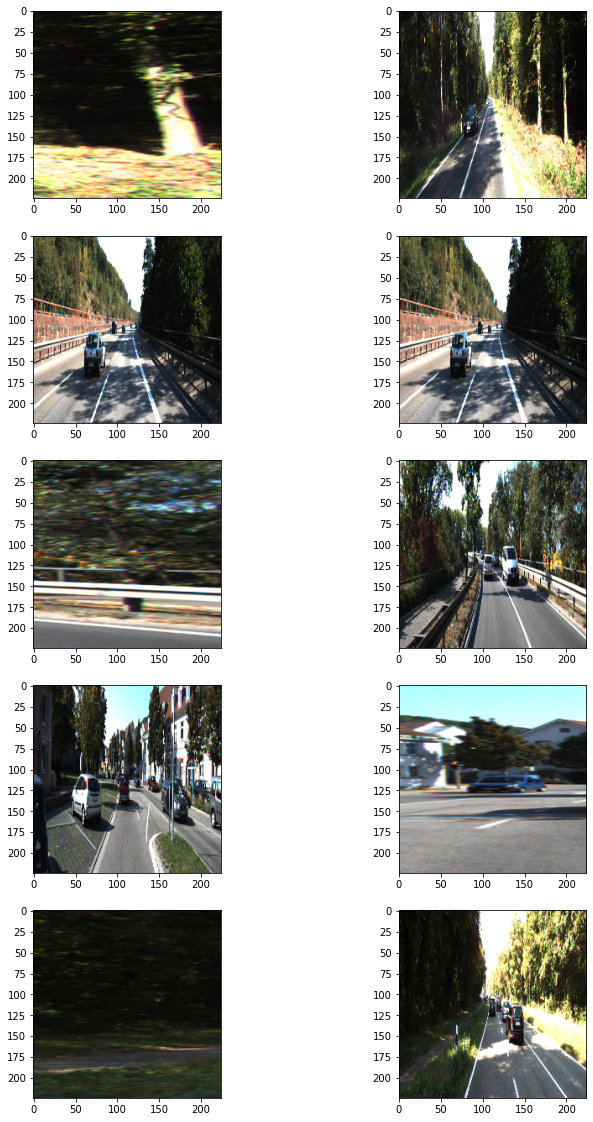

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 2. U-Net & U-Net++ 모델 구현

### 1) U-Net 모델

In [6]:
# 모델 구조 만들기
def U_Net(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [7]:
U_Net_model = U_Net()
U_Net_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
# 모델 학습하기
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = U_Net()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델 저장

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 60s 644ms/step - loss: 0.6324 - val_loss: 0.1027
Epoch 2/100
43/43 [==============================] - 27s 624ms/step - loss: 0.1119 - val_loss: 0.0971
Epoch 3/100
43/43 [==============================] - 27s 629ms/step - loss: 0.1610 - val_loss: 0.0862
Epoch 4/100
43/43 [==============================] - 27s 627ms/step - loss: 0.0862 - val_loss: 0.0883
Epoch 5/100
43/43 [==============================] - 27s 626ms/step - loss: 0.0796 - val_loss: 0.0824
Epoch 6/100
43/43 [==============================] - 27s 629ms/step - loss: 0.0772 - val_loss: 0.0769
Epoch 7/100
43/43 [==============================] - 27s 629ms/step - loss: 0.0706 - val_loss: 0.0762
Epoch 8/100
43/43 [==============================] - 27s 631ms/step - loss: 0.0730 - val_loss: 0.0740
Epoch 9/100
43/43 [==============================] - 27s 632ms/step - loss: 0.0710 - val_loss: 0.0747
Epoch 10/100
43/43 [==============================] - 27s 634ms/step - loss: 0.065

43/43 [==============================] - 27s 640ms/step - loss: 0.0383 - val_loss: 0.0710
Epoch 81/100
43/43 [==============================] - 27s 638ms/step - loss: 0.0431 - val_loss: 0.0484
Epoch 82/100
43/43 [==============================] - 27s 639ms/step - loss: 0.0362 - val_loss: 0.0519
Epoch 83/100
43/43 [==============================] - 27s 638ms/step - loss: 0.0365 - val_loss: 0.0602
Epoch 84/100
43/43 [==============================] - 27s 638ms/step - loss: 0.0460 - val_loss: 0.0814
Epoch 85/100
43/43 [==============================] - 28s 641ms/step - loss: 0.0295 - val_loss: 0.0468
Epoch 86/100
43/43 [==============================] - 27s 640ms/step - loss: 0.0424 - val_loss: 0.0578
Epoch 87/100
43/43 [==============================] - 28s 640ms/step - loss: 0.0477 - val_loss: 0.0429
Epoch 88/100
43/43 [==============================] - 27s 637ms/step - loss: 0.0389 - val_loss: 0.0497
Epoch 89/100
43/43 [==============================] - 27s 637ms/step - loss: 0.0336 - 

### 2) U-Net++ 모델

In [9]:
def U_Net_plus(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # Contracting Path
    # X0,0
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X0_0_conv1')(inputs)
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X0_0_conv2')(conv0_0)
    pool0_0 = MaxPooling2D(pool_size=(2, 2), name='X0_0_pool')(conv0_0)
    
    # X1,0
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X1_0_conv1')(pool0_0)
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X1_0_conv2')(conv1_0)
    pool1_0 = MaxPooling2D(pool_size=(2, 2), name='X1_0_pool')(conv1_0)
    
    # X2,0
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X2_0_conv1')(pool1_0)
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X2_0_conv2')(conv2_0)
    pool2_0 = MaxPooling2D(pool_size=(2, 2), name='X2_0_pool')(conv2_0)
    
    # X3,0
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X3_0_conv1')(pool2_0)
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X3_0_conv2')(conv3_0)
    pool3_0 = MaxPooling2D(pool_size=(2, 2), name='X3_0_pool')(conv3_0)
    
    # X4,0
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X4_0_conv1')(pool3_0)  
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X4_0_conv2')(conv4_0)


    # Expanding Path 1
    # X0.1
    up1_0 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal', name='X1_0_up')(UpSampling2D(size = (2,2))(conv1_0)) 
    merge0_1 = concatenate([up1_0, conv0_0], axis = 3, name='X0_1_merge')
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X0_1_conv1')(merge0_1)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X0_1_conv2')(conv0_1)
   
    # X1,1
    up2_0 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal', name='X2_0_up')(UpSampling2D(size = (2,2))(conv2_0))
    merge1_1 = concatenate([up2_0, conv1_0], axis = 3, name='X1_1_merge')
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X1_1_conv1')(merge1_1)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X1_1_conv2')(conv1_1)
    
    # X2,1
    up3_0 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal', name='X3_0_up')(UpSampling2D(size = (2,2))(conv3_0))
    merge2_1 = concatenate([up3_0, conv2_0], axis = 3, name='X2_1_merge')
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X2_1_conv1')(merge2_1)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X2_1_conv2')(conv2_1)
    
    # X3,1
    up4_0 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal', name='X4_0_up')(UpSampling2D(size = (2,2))(conv4_0))
    merge3_1 = concatenate([up4_0, conv3_0], axis = 3, name='X3_1_merge')
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X3_1_conv1')(merge3_1)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X3_1_conv2')(conv3_1)  


    # Expanding Path 2
    # X0,2
    up1_1 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal', name='X1_1_up')(UpSampling2D(size = (2,2))(conv1_1)) 
    merge0_2 = concatenate([up1_1, conv0_0, conv0_1], axis = 3, name='X0_2_merge')
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X0_2_conv1')(merge0_2)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X0_2_conv2')(conv0_2)
    
    # X1,2
    up2_1 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal', name='X2_1_up')(UpSampling2D(size = (2,2))(conv2_1))
    merge1_2 = concatenate([up2_1, conv1_0, conv1_0], axis = 3, name='X1_2_merge')
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X1_2_conv1')(merge1_2)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X1_2_conv2')(conv1_2)
    
    # X2,2
    up3_1 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal', name='X3_1_up')(UpSampling2D(size = (2,2))(conv3_1))
    merge2_2 = concatenate([up3_1, conv2_0, conv2_1], axis = 3, name='X2_2_merge')
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X2_2_conv1')(merge2_2)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X2_2_conv2')(conv2_2)


    # Expanding Path 3
    # X0,3
    up1_2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal', name='X1_2_up')(UpSampling2D(size = (2,2))(conv1_2)) 
    merge0_3 = concatenate([up1_2, conv0_0, conv0_1, conv0_2], axis = 3, name='X0_3_merge')
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X0_3_conv1')(merge0_3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X0_3_conv2')(conv0_3)
    # X1,3
    up2_2 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal', name='X2_2_up')(UpSampling2D(size = (2,2))(conv2_2))
    merge1_3 = concatenate([up2_2, conv1_0, conv1_1, conv1_2], axis = 3, name='X1_3_merge')
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X1_3_conv1')(merge1_3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X1_3_conv2')(conv1_3)
    

    # Expanding Path 4
    # X0,4
    up1_3 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal', name='X1_3_up')(UpSampling2D(size = (2,2))(conv1_3)) 
    merge0_4 = concatenate([up1_3, conv0_0, conv0_1, conv0_2, conv0_3], axis = 3, name='X0_4_merge')
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X0_4_conv1')(merge0_4)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X0_4_conv2')(conv0_4)
    
    output = Conv2D(1, 1, activation='sigmoid', name='output')(conv0_4)
    model = Model(inputs = inputs, outputs = output)

    return model

In [10]:
U_Net_plus_model = U_Net_plus()
U_Net_plus_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
X0_0_conv1 (Conv2D)             (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
X0_0_conv2 (Conv2D)             (None, 224, 224, 64) 36928       X0_0_conv1[0][0]                 
__________________________________________________________________________________________________
X0_0_pool (MaxPooling2D)        (None, 112, 112, 64) 0           X0_0_conv2[0][0]                 
____________________________________________________________________________________________

In [11]:
# 모델 학습하기
model_plus_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus.h5'

model = U_Net_plus()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_plus_path)  #학습한 모델 저장

Epoch 1/100
43/43 [==============================] - 123s 2s/step - loss: 0.5934 - val_loss: 0.1294
Epoch 2/100
43/43 [==============================] - 86s 2s/step - loss: 0.1301 - val_loss: 0.0870
Epoch 3/100
43/43 [==============================] - 87s 2s/step - loss: 0.1176 - val_loss: 0.1061
Epoch 4/100
43/43 [==============================] - 86s 2s/step - loss: 0.0943 - val_loss: 0.0855
Epoch 5/100
43/43 [==============================] - 86s 2s/step - loss: 0.0862 - val_loss: 0.0723
Epoch 6/100
43/43 [==============================] - 86s 2s/step - loss: 0.0676 - val_loss: 0.0762
Epoch 7/100
43/43 [==============================] - 86s 2s/step - loss: 0.0602 - val_loss: 0.0615
Epoch 8/100
43/43 [==============================] - 86s 2s/step - loss: 0.0724 - val_loss: 0.0915
Epoch 9/100
43/43 [==============================] - 86s 2s/step - loss: 0.0626 - val_loss: 0.0799
Epoch 10/100
43/43 [==============================] - 86s 2s/step - loss: 0.0598 - val_loss: 0.0665
Epoch 11

43/43 [==============================] - 85s 2s/step - loss: 0.0339 - val_loss: 0.0503
Epoch 84/100
43/43 [==============================] - 85s 2s/step - loss: 0.0387 - val_loss: 0.0423
Epoch 85/100
43/43 [==============================] - 85s 2s/step - loss: 0.0458 - val_loss: 0.0604
Epoch 86/100
43/43 [==============================] - 85s 2s/step - loss: 0.0384 - val_loss: 0.0507
Epoch 87/100
43/43 [==============================] - 85s 2s/step - loss: 0.0444 - val_loss: 0.0538
Epoch 88/100
43/43 [==============================] - 85s 2s/step - loss: 0.0294 - val_loss: 0.0399
Epoch 89/100
43/43 [==============================] - 86s 2s/step - loss: 0.0407 - val_loss: 0.0489
Epoch 90/100
43/43 [==============================] - 86s 2s/step - loss: 0.0360 - val_loss: 0.0420
Epoch 91/100
43/43 [==============================] - 85s 2s/step - loss: 0.0350 - val_loss: 0.0414
Epoch 92/100
43/43 [==============================] - 85s 2s/step - loss: 0.0256 - val_loss: 0.0702
Epoch 93/100


## 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

In [13]:
U_Net = tf.keras.models.load_model(model_path)
U_Net_plus = tf.keras.models.load_model(model_plus_path)

### 1) 시각화 비교

In [14]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

#### * U-Net

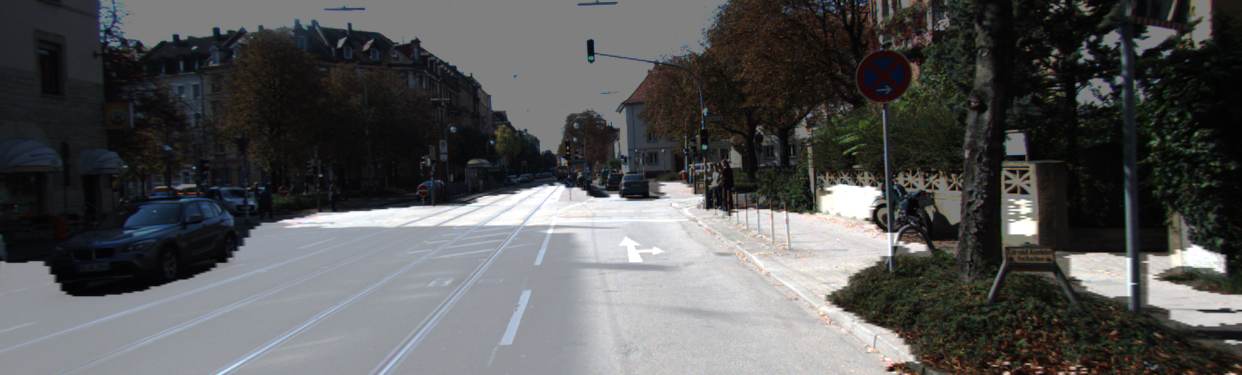

In [15]:
i = 1   
get_output(
     U_Net, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

#### * U-Net++

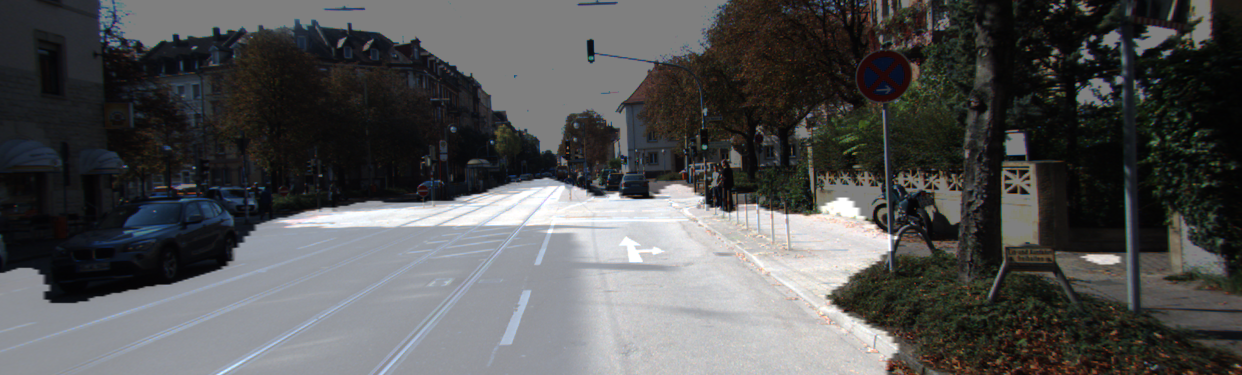

In [17]:
i = 1   
get_output(
     U_Net_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

### 2) IoU 비교

In [19]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [20]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

#### * U-Net

In [21]:
i = 1
output, prediction, target = get_output(
     U_Net, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.808025


0.8080249723613189

#### * U-Net++

In [23]:
i = 1
output, prediction, target = get_output(
     U_Net_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.855627


0.8556267659017297

## 4. 결과

#### # 시각화 비교
* U-Net과 다르게, U-Net++ 이미지는 도로와 객체 사이의 경계선 부분도 더욱 명확하게 세그멘테이션 됬음
* 세그멘테이션 대상이 아닌 것들도, U-Net 결과와 다르게, 어둡게 처리 함을 알 수 있음  

#### # IoU 비교
|model|IoU|
|:---|:---:|
|U-Net|0.808025|
|U-Net++|0.855627|

 * U-Net++ 모델이 더좋은 성능을 보임

#### # 회고
* 모델 성능 향상을 위해, Dropout, BatchNormalization 등을 추가하면 좋다고 함
* unet에서 개선된 모델들이 많았음. 이후 새로운 아키텍처 구현 목표.